In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import scipy

In [3]:
data = pd.read_csv('US_City_Temp_Data.csv')
nb_rows, nb_columns = data.shape
T = np.zeros((nb_columns-1, nb_rows))           ## Array where each element is an array with the temperatures of a city over the years
t = np.array(data.iloc[:, 0])                   ## Array with the dates of temperature measurement
cities = np.array(data.columns[1:])             ## Array with the names of the cities
i = 0
for city in cities:
     T[i] = np.array(data[city])
     i += 1



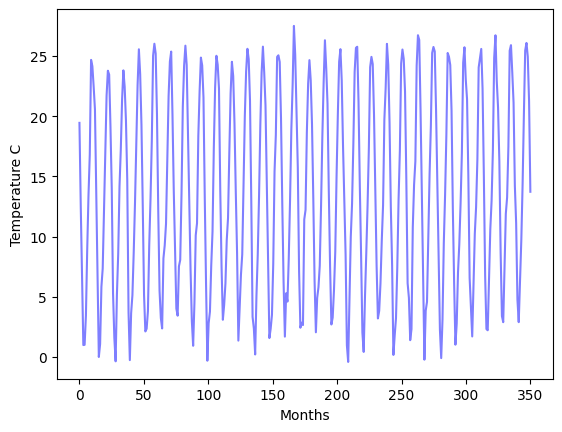

In [299]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

months = np.arange(1, 900)
# Generate a list of values from 1 to 899
nb_working_months = 850
## Define the number of validation months
nb_of_validation_months = len(months) - nb_working_months

start = 500

## create the validation and work (train + test) datasets
working_months = months[start:nb_working_months]
months_validation = months[start:nb_working_months+nb_of_validation_months]

city_number = 0;    ##Albuquerque

Ti = T[city_number][start:nb_working_months]
Tv = T[city_number][start:nb_working_months+nb_of_validation_months]

Ti = Ti.reshape(nb_working_months-start, 1)
working_months = np.linspace(0, nb_working_months-start, nb_working_months-start).reshape(-1, 1)
Tv = Tv.reshape(nb_working_months+nb_of_validation_months-start, 1)
months_validation = np.linspace(1, nb_of_validation_months+nb_working_months-start, nb_of_validation_months+nb_working_months-start).reshape(-1, 1)


# We can plot the dataset and the original non-linear function
plt.plot(working_months, Ti, c='b', alpha=0.5)
plt.xlabel('Months')
plt.ylabel('Temperature C')
plt.show()

Epoch [100/3000], Loss: 138.8029, Test loss: 102.1218
Epoch [200/3000], Loss: 95.8936, Test loss: 72.5411
Epoch [300/3000], Loss: 84.2277, Test loss: 71.8608
Epoch [400/3000], Loss: 81.9794, Test loss: 71.7811
Epoch [500/3000], Loss: 81.0744, Test loss: 71.7544
Epoch [600/3000], Loss: 80.3688, Test loss: 71.6848
Epoch [700/3000], Loss: 79.7462, Test loss: 71.5574
Epoch [800/3000], Loss: 79.1874, Test loss: 71.3729
Epoch [900/3000], Loss: 78.6800, Test loss: 71.3365
Epoch [1000/3000], Loss: 78.2066, Test loss: 71.2579


KeyboardInterrupt: 

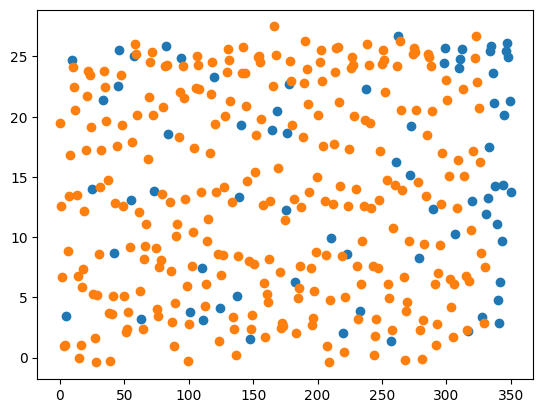

In [301]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the neural network architecture
class NewNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(NewNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Initialize weights
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0.0)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

# scaler = StandardScaler()
# working_months = scaler.fit_transform(working_months)
# Ti = scaler.fit_transform(Ti)
def train_model():
    # Parameters
    input_size = 1
    num_layers = 20
    hidden_size = 24
    output_size = 1
    model = NewNetwork(input_size, hidden_size, output_size, num_layers)

    nb_test = 20

    from sklearn.model_selection import train_test_split
    months_train, months_test, T_train, T_test = train_test_split(
    working_months[:-nb_test], Ti[:-nb_test], test_size=0.15, random_state=42)

    months_test = np.concatenate((months_test, working_months[-nb_test:]), axis=0)
    T_test = np.concatenate((T_test, Ti[-nb_test:]), axis=0)
    plt.scatter(months_test, T_test)
    plt.scatter(months_train, T_train)
    # Convert data to PyTorch tensors
    months_train = torch.tensor(months_train, dtype=torch.float32)
    months_test = torch.tensor(months_test, dtype=torch.float32)
    T_train = torch.tensor(T_train, dtype=torch.float32)
    T_test = torch.tensor(T_test, dtype=torch.float32)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    lambda_reg = 0.03
    # Training loop
    num_epochs = 3000
    for epoch in range(num_epochs):

        # Forward pass
        output = model(months_train)
        # Compute loss on training data
        loss = criterion(output, T_train)

        ## regularization
        l1_regularization = 0.01
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)

        loss += lambda_reg * l1_regularization

        # Compute loss on testing data. NOTE: we aren't gonna use the test loss for optimization!!!
        output_test = model(months_test)
        loss_test = criterion(output_test, T_test)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')

    return model



model = train_model()





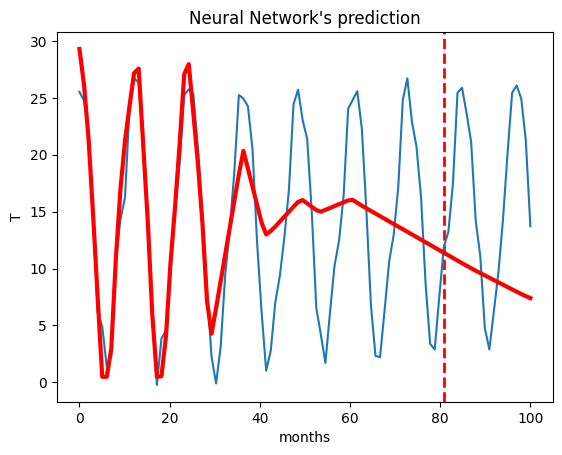

In [296]:
nb_test = 20

# months_validation = torch.tensor(scaler.fit_transform(months_validation))
# Tv = torch.tensor(scaler.fit_transform(Tv), dtype = torch.float32)
with torch.no_grad():
    T_pred = model(torch.tensor(working_months, dtype=torch.float32))
plt.axvline(working_months[-nb_test], color='red', linestyle='--', linewidth=2)

plt.plot(working_months, Ti)
plt.plot(working_months, T_pred.numpy(), c='red', lw=3, label='Predicted Curve')
plt.xlabel('months')
plt.ylabel('T')
plt.title("Neural Network's prediction")
plt.show()
